In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage

from matplotlib.colors import ListedColormap
from scipy.optimize import minimize, Bounds

In [2]:
# ------ import color palettes ------
df = pd.read_excel('./palette.xlsx', sheet_name='final')
palettes = {}
for row in df.values:
    palettes[row[0]] = [row[2:5].tolist(), row[6:9].tolist(), row[10:13].tolist(), row[14:17].tolist(), row[18:].tolist()]

In [3]:
# # ------ plot palettes ------
# fig = plt.figure(figsize=(5, 20))
# for i, (k, v) in enumerate(palettes.items()):
#     ax = fig.add_subplot(25, 2, i+1)
#     data = np.array([[0, 1, 2, 3, 4]])
#     ori_pa = (np.array(v)/255.).tolist()
#     cmap = ListedColormap(ori_pa)
#     ax.imshow(data, cmap=cmap)
#     ax.set_axis_off()
#     plt.title(k)
# plt.show()

> [method](https://msgsxj.cn/2019/02/20/SciPy%E4%B8%AD%E7%9A%84%E7%BB%8F%E5%85%B8%E4%BC%98%E5%8C%96%E7%AE%97%E6%B3%95/)

'SLSQP' 是 Scipy 中的一種最佳化方法，它是 Sequential Least SQuares Quadratic Programming（序列最小平方二次規劃）的縮寫。它主要適用於存在限制條件（包括等式約束和不等式約束）的最佳化問題，並且可以處理包含不連續點的問題。這使得 'SLSQP' 在處理一些實際應用中的複雜最佳化問題時表現出色。

在這個例子中，目標函式是計算總距離，並且存在一個調整亮度的係數，需要滿足相應的限制條件。因此，選擇 'SLSQP' 方法作為最佳化方法是合理的，因為它可以處理這些限制條件，並在適用的情況下找到全局最小值。然而，最佳化方法的選擇也取決於具體的問題需求和性能要求，不同的最佳化方法可能在不同情況下表現出更好的效果。在實際應用中，可以通過嘗試不同的最佳化方法並比較它們的結果，選擇最適合問題需求的方法。

---

為什麼選擇了 SLSQP 而不是 CG、BFGS、L-BFGS-B、TNC 等其他方法，實際上是基於以下原因：

約束條件：SLSQP（Sequential Least Squares Quadratic Programming）是一種適用於帶有等式和不等式約束的最佳化問題的方法。在你的代碼中，你並未提供約束函式，但你的目標函式中存在一個亮度調整的約束條件，這導致了一個帶有等式約束的最佳化問題。因此，選擇 SLSQP 方法可以處理這種帶有約束條件的問題。

效能：SLSQP 方法通常在處理帶有等式和不等式約束的最佳化問題時效能較好。而 CG、BFGS、L-BFGS-B、TNC 等方法則通常用於無約束最佳化問題，效能可能在處理帶有約束條件的問題時較低。

總而言之，選擇最適合的最佳化方法取決於具體的問題設定和需求。如果你的問題具有等式或不等式約束，並且希望在處理這些約束時保持較高的效能，那麼 SLSQP 可能是一個合適的選擇。如果你的問題是無約束的最佳化問題，那麼 CG、BFGS、L-BFGS-B、TNC 等方法也可以是適合的選擇。

In [4]:
print(palettes['mood of Nov 4'])

[[204, 137, 153], [206, 230, 232], [120, 102, 153], [203, 133, 204], [142, 153, 255]]


In [5]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

# 目標函式
def objective(params, inputs):
    L_values = params[::3]
    a_values = params[1::3]
    b_values = params[2::3]
    num_inputs = inputs.shape[1]
    total_distance = 0
    for i in range(num_inputs):
        L_diff = L_values[i] - inputs[0, i]
        a_diff = a_values[i] - inputs[1, i]
        b_diff = b_values[i] - inputs[2, i]
        distance = np.sqrt(L_diff ** 2 + a_diff ** 2 + b_diff ** 2)
        total_distance += distance

        # 調整亮度
        L_diff = L_values[i] - initial_params[3 * i]
        total_distance += np.abs(L_diff) * distance / (distance + 1) * 0.01
        # total_distance += np.abs(L_diff) * (1 / (distance + 1))

    return total_distance

# 輸入值
inputs = np.array([[50, 40, 90],
                  [50, 40, 90],
                  [50, 80, 90]])
initial_params = inputs.flatten()
bounds = Bounds([0, 0, 0, -100, -100, -100, -100, -100, -100], [100, 100, 100, 100, 100, 100, 100, 100, 100])

# 最佳化
result = minimize(objective, initial_params, args=(inputs,), method='SLSQP', bounds=bounds)
optimized_params = result.x
optimized_L_values = optimized_params[::3]
optimized_a_values = optimized_params[1::3]
optimized_b_values = optimized_params[2::3]

print("最佳化後的 L 值：", optimized_L_values)
print("最佳化後的 a 值：", optimized_a_values)
print("最佳化後的 b 值：", optimized_b_values)


最佳化後的 L 值： [50.0000005  39.99999841 90.00000087]
最佳化後的 a 值： [49.99999853 39.99999919 90.00000043]
最佳化後的 b 值： [50.00000245 80.00000316 90.00000018]


In [6]:
rgb = []
for l, a, b in zip(optimized_L_values, optimized_a_values, optimized_b_values):
    rgb.append(skimage.color.lab2rgb([l, a, b]).tolist())
print(rgb)

[[0.8102357557989095, 0.29585756483995396, 0.13143053956644832], [0.6498236548500084, 0.23893414414741226, 0.0], [1.0, 0.5173121914206096, 0.18412793485943743]]


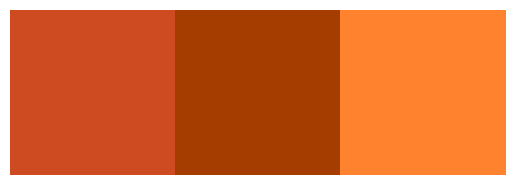

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
data = np.array([[0, 1, 2]])
ori_pa = rgb
cmap = ListedColormap(ori_pa)
ax.imshow(data, cmap=cmap)
ax.set_axis_off()
plt.show()

In [8]:
inputs = np.array([[50, 40, 90],
                  [50, 40, 90],
                  [50, 80, 90]], dtype=np.float32)

rgb = []
for l, a, b in inputs:
    rgb.append(skimage.color.lab2rgb([l, a, b]).tolist())
print(rgb)

[[0.7735773654669542, 0.3382564224369352, 0.0], [0.7735773654669542, 0.3382564224369352, 0.0], [0.959939734418419, 0.0, 0.0]]


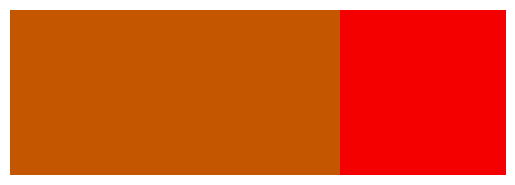

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
data = np.array([[0, 1, 2]])
ori_pa = rgb
cmap = ListedColormap(ori_pa)
ax.imshow(data, cmap=cmap)
ax.set_axis_off()
plt.show()